In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import copy
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
sys.path.append(parent_dir)

# Regular Imports 
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from tqdm import tqdm
import matplotlib.pyplot as plt

from inference.distribution import Gaussian

# Distributions

## Target Distribution $\phi^4$
We load premade samples from a `torch.Tensor` of shape `(batch_size, lattice_points, lattice_points)`

In [3]:
from inference.distribution import Sampleable
class EmpiricalPhi4(Sampleable):

    def __init__(self, samples: torch.Tensor, device = None):
        self._samples = samples.to(device)
        self._lattice_size = int(samples.shape[-1])
        
    @property
    def dim(self):
        shape = self._samples.shape
        return shape[-1] * shape[-2]

    def sample(self, num_samples: int):
        '''
        Returns
            Shape (num_samples, L, L)
        '''
        batch_size = self._samples.shape[0]
        if num_samples > batch_size:
            raise ValueError(f"num_samples ({num_samples}) cannot exceed batch_size ({batch_size})")

        indices = torch.randperm(batch_size)[:num_samples]
        return self._samples[indices]
    

# Load Phi4 Samples
samples = torch.load('phi4_coupling0p02_kinetic0p3.pt', map_location=torch.device('cpu')) # Shape (batch_size, L, L)
dist_phi4 = EmpiricalPhi4(samples=samples, device=device)

/state/partition1/job-60476561/ipykernel_2941401/4071969165.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  samples = torch.load('phi4_coupling0p02_kinetic0p3.pt', map_

## Easy to Sample Distribution

In [9]:
class GaussianNoise(Sampleable):

    def __init__(self, lattice_size, device = None):
        self._lattice_size = lattice_size
        self.device = device

    @property
    def dim(self):
        return self._lattice_size ** 2
    
    def sample(self, num_samples: int) -> torch.Tensor:
        return torch.rand(num_samples, self._lattice_size, self._lattice_size, device=self.device)

# Machine Learning

## Trainer

In [4]:
from inference.sde import SDE, EulerMaruyamaSimulator
from inference.path import ConditionalProbabilityPath
from learning.train import Trainer
from learning.mlp import MLPVectorField

class LangevinDynamics(SDE):
    ''' 
    Implements

    dX_t = (sigma_t^2 / 2) s(x) dt + sigma_t dW_t
    
    where s(x) = nabla_x log p(x)
    '''
    
    def __init__(self, score, noise_scheduler: torch.Tensor):
        '''
        The score is of the form `\nabla_x \log p(x)`

        The limiting distribution of LangevinDynamics is `p(x)`

        Args:
            score (func): Inputs tensor of shape (batch_size, dim), outputs tensor of shape (batch_size, dim).
                Can be `distribution.Density.score`.
            noise_scheduler: Inputs torch tensor (batch_size, 1), outputs tensor of shape (batch_size, 1)
        '''
        self.score = score
        self.noise_scheduler = noise_scheduler

    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor):
        '''
        Args:
            xt: (batch_size, L, L)
            t: (batch_size, 1, 1)
        Returns:
            drift: (batch_size, L, L)
        '''
        _, dim, dim = xt.shape
        # noise = self.noise_scheduler(t).repeat(1, dim, dim)

        t = t.repeat(xt.shape[0], 1, 1)
        return self.score(xt, t)
    
    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor):
        _, dim, dim = xt.shape
        noise = self.noise_scheduler(t).repeat(1, dim)

        return noise

class ConditionalFlowMatchingTrainer(Trainer):
    def __init__(self, 
                 path: ConditionalProbabilityPath, 
                 model: MLPVectorField,
                 **kwargs):
        super().__init__(model, **kwargs)
        self.path = path

    def get_train_loss(self, batch_size: int) -> torch.Tensor:
        z = self.path.p_data.sample(batch_size)
        t = torch.rand(batch_size, 1, 1, device=device) # (batch_size, 1, 1)
        x = self.path.sample_conditional_path(z,t) # (batch_size, lattice_size, lattice_size)

        u_model = self.model(x,t)
        u_ref = self.path.conditional_vector_field(x,z,t)

        return torch.norm(u_model - u_ref) / batch_size
    
    def inference(self, 
                  num_samples: int,
                  ts: torch.Tensor,
                  use_tqdm: bool = False
                  ):
        sde = LangevinDynamics(score=self.model, noise_scheduler=lambda t: torch.ones_like(t))
        simulator= EulerMaruyamaSimulator(sde)
        
        x_init = self.path.p_data.sample(num_samples)
        x_final = simulator.simulate(x=x_init, ts=ts, use_tqdm=use_tqdm)

        return x_final

<>:16: SyntaxWarning: invalid escape sequence '\l'
<>:16: SyntaxWarning: invalid escape sequence '\l'
/state/partition1/job-60476561/ipykernel_2941401/1177913704.py:16: SyntaxWarning: invalid escape sequence '\l'
  '''


## Training

In [14]:
from learning.mlp import MLPVectorField
from inference.path import LinearConditionalProbabilityPath

# Construct conditional probability path
path = LinearConditionalProbabilityPath(
    p_simple = GaussianNoise(lattice_size=dist_phi4._lattice_size, device=device),
    p_data = dist_phi4
).to(device)

# Construct learnable vector field
hiddens = [256,256,256,256,256]
time_embed_dim = 64
linear_flow_model = MLPVectorField(dim=dist_phi4.dim, hiddens=hiddens, time_embed_dim=time_embed_dim)

# Construct trainer

setup_optimizer = dict(weight_decay=1e-4)
setup_loss = dict(batch_size=8000)

trainer = ConditionalFlowMatchingTrainer(path, linear_flow_model)
losses = trainer.train(num_epochs=10000, 
                       device=device, 
                       lr=1e-5, 
                       setup_optimizer=setup_optimizer, 
                       setup_loss=setup_loss)

Epoch 5447, loss: 0.20466503500938416: : 5448it [00:39, 138.74it/s]


KeyboardInterrupt: 

In [13]:
losses = trainer.train(num_epochs=10000, 
                       device=device, 
                       lr=1e-6, 
                       setup_optimizer=setup_optimizer, 
                       setup_loss=setup_loss)

Epoch 939, loss: 0.20652364194393158: : 934it [00:06, 139.61it/s]Exception ignored in: <generator object tqdm.__iter__ at 0x14efe89bd900>
Traceback (most recent call last):
  File "/ext3/miniforge3/lib/python3.12/site-packages/tqdm/std.py", line 1196, in __iter__
    self.close()
  File "/ext3/miniforge3/lib/python3.12/site-packages/tqdm/std.py", line 1275, in close
    self._decr_instances(self)
  File "/ext3/miniforge3/lib/python3.12/site-packages/tqdm/std.py", line 696, in _decr_instances
    with cls._lock:
         ^^^^^^^^^
KeyboardInterrupt: 


KeyboardInterrupt: 

# Results
## Visual

100%|██████████| 999/999 [00:00<00:00, 1640.71it/s]


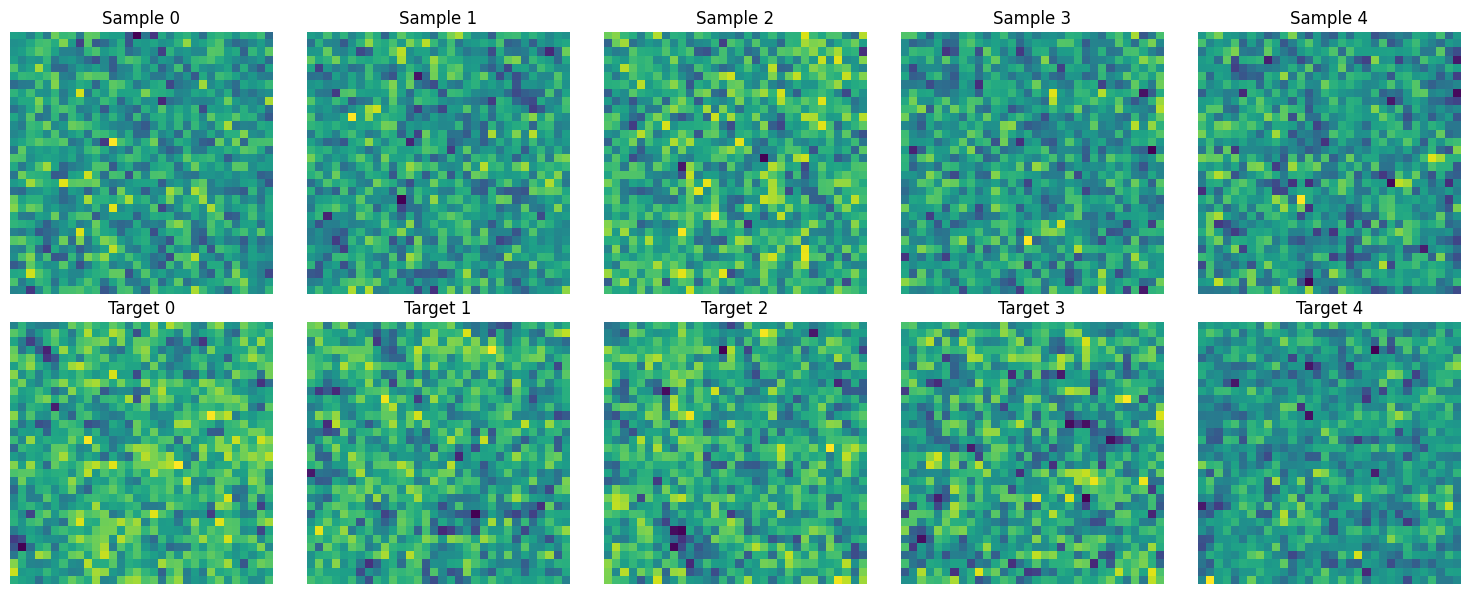

In [12]:
num_samples = 1000

ts = torch.linspace(0, 1, 1000).unsqueeze(-1).unsqueeze(-1).to(device)
samples = trainer.inference(num_samples=num_samples, ts=ts, use_tqdm=True)

# Plot some samples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axes[0, i].imshow(samples[i].cpu().detach())
    axes[0, i].set_title(f'Sample {i}')
    axes[0, i].axis('off')
    
    # Plot corresponding target samples for comparison
    target_sample = dist_phi4.sample(1)[0]
    axes[1, i].imshow(target_sample.cpu().detach())
    axes[1, i].set_title(f'Target {i}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## Statistical Tests

+-----------+------------------+---------------------+---------------+
| Statistic | Generative Model | Target Distribution | In Tolerance? |
+-----------+------------------+---------------------+---------------+
|     M     | 4.3934 ± 0.0025  |   2.1946 ± 0.0005   |     False     |
|    |M|    | 4.3934 ± 0.0025  |   2.1946 ± 0.0005   |     False     |
|   chi²    | 6.3028 ± 22.3089 |   1.5274 ± 2.4534   |     True      |
+-----------+------------------+---------------------+---------------+


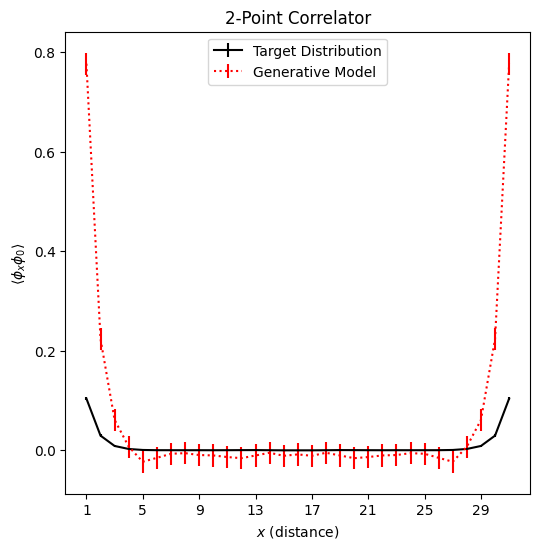

In [11]:
from fieldstatistics import compare_statistics

num_samples = 5000
compare_statistics(samples, dist_phi4.sample(num_samples))